### XGBoost, lightGBM, sklearn Model, statsModel만 가능 
### 아무런 조건을 주지 않은 모델을 돌려보기 

## 라이브러리 로드

In [1]:
import pandas as pd
import xgboost
import lightgbm
import matplotlib.pyplot as plt

# sklearn
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 다중 로지스틱 회귀, XGBoost, LightGBM, AdaBoost, randomforest, 서포트벡터머신 5개 비교

In [116]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## 데이터 로드

In [80]:
data_path = 'C:/Users/OS/DACON/데이크루6기/신용카드 사기 거래 탐지/open/'
Train = pd.read_csv(data_path + 'train.csv')
Test = pd.read_csv(data_path + 'test.csv')

In [3]:
Train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [4]:
Test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


### occyp_type, index 컬럼 삭제
- 모델 학습에 필요없는 컬럼 - index
- occyp_type - 결측값이 너무 많은 컬럼

In [81]:
# 컬럼삭제 
Train = Train.drop(['index','occyp_type'], axis=1)

# Train의 라벨인 credit 값 추출
Y_Train = Train.pop('credit')

### Train 유무 변수에 대해 라벨 인코딩 실행 - gender, car, reality

In [55]:
Train.head(1)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,2.0,-6.0


In [82]:
label_encoder = LabelEncoder()
Train['gender'] = label_encoder.fit_transform(Train['gender'])
Train['car'] = label_encoder.fit_transform(Train['car'])
Train['reality'] = label_encoder.fit_transform(Train['reality'])

In [77]:
Train.head(3)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,2.0,-6.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,3.0,-5.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,2.0,-22.0


### Trian 종류를 나타내는 변수에 대해 원-핫 인코딩 실행(pd.getdummies이용)
### income_type, edu_type, family_type, house_type

In [60]:
len(Train['income_type'])

26457

In [84]:
Train = pd.get_dummies(Train, drop_first=True)

In [85]:
Train.head(3)

,gender,car,reality,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,...,edu_type_Secondary / secondary special,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0,0,0,0,202500.0,-13899,-4709,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,1,1,247500.0,-11380,-1540,1,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,1,1,0,450000.0,-19087,-4434,1,0,1,...,0,1,0,0,0,1,0,0,0,0


## 훈련, 검증, 테스트 세트 분할

In [141]:
from sklearn.model_selection import train_test_split
x_train , x_test, y_train,y_test = train_test_split(Train, Y_Train, stratify = Y_Train,test_size=0.2, random_state=7)

In [142]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

21165 21165 5292 5292


# XGBoost

In [143]:
xgb_model = xgboost.XGBClassifier(random_state=7)
xgb_model.fit(x_train, y_train)
pred = xgb_model.predict(x_test)
print(pred)

[2 2 2 ... 0 2 2]


정확도 : 0.7061602418745276


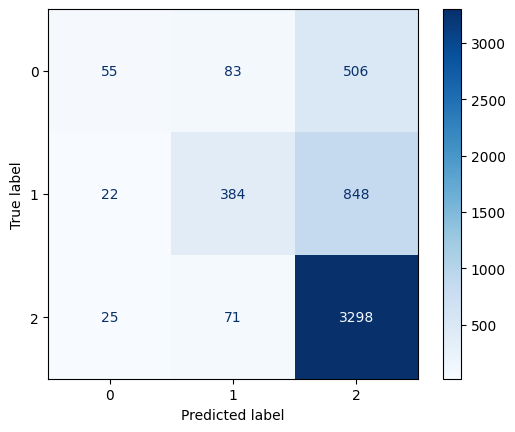

              precision    recall  f1-score   support

         0.0       0.54      0.09      0.15       644
         1.0       0.71      0.31      0.43      1254
         2.0       0.71      0.97      0.82      3394

    accuracy                           0.71      5292
   macro avg       0.65      0.45      0.47      5292
weighted avg       0.69      0.71      0.65      5292



In [144]:
# 정확도
xgb_acc = accuracy_score(y_test,pred)
print('정확도 :', xgb_acc)
# 혼동행렬
xgb_confusion = confusion_matrix(y_test,pred)
xgb_disp = ConfusionMatrixDisplay(xgb_confusion, display_labels=['0','1','2'])
xgb_disp.plot(cmap=plt.cm.Blues)
plt.show()
# 분석 보고서
xgb_classification_report = classification_report(y_test,pred)
print(xgb_classification_report)

## AdaBoostClassifier

In [149]:
Ada_model = AdaBoostClassifier(random_state=7)
Ada_model.fit(x_train, y_train)
Ada_pred = Ada_model.predict(x_test)
print(Ada_pred)

[2. 2. 2. ... 2. 2. 2.]


정확도 : 0.6940665154950869


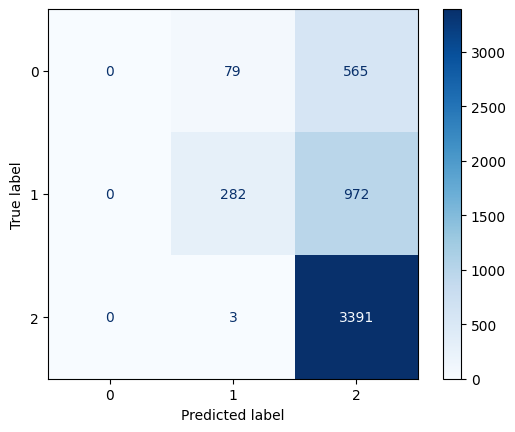

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       644
         1.0       0.77      0.22      0.35      1254
         2.0       0.69      1.00      0.81      3394

    accuracy                           0.69      5292
   macro avg       0.49      0.41      0.39      5292
weighted avg       0.62      0.69      0.61      5292



C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [150]:
# 정확도
Ada_acc = accuracy_score(y_test,Ada_pred)
print('정확도 :', Ada_acc)
# 혼동행렬
Ada_confusion = confusion_matrix(y_test,Ada_pred)
Ada_disp = ConfusionMatrixDisplay(Ada_confusion, display_labels=['0','1','2'])
Ada_disp.plot(cmap=plt.cm.Blues)
plt.show()
# 분석 보고서
Ada_classification_report = classification_report(y_test,Ada_pred)
print(Ada_classification_report)

## RandomForestClassifier

In [147]:
RF_model = RandomForestClassifier(random_state=7)
RF_model.fit(x_train, y_train)
RF_pred = RF_model.predict(x_test)
print(RF_pred)

[0. 0. 2. ... 0. 2. 2.]


정확도 : 0.7044595616024187


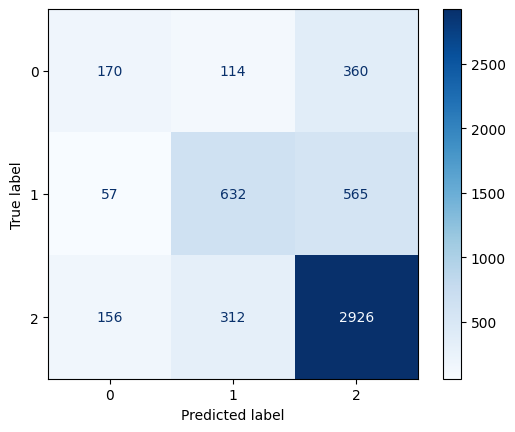

              precision    recall  f1-score   support

         0.0       0.44      0.26      0.33       644
         1.0       0.60      0.50      0.55      1254
         2.0       0.76      0.86      0.81      3394

    accuracy                           0.70      5292
   macro avg       0.60      0.54      0.56      5292
weighted avg       0.68      0.70      0.69      5292



In [148]:
# 정확도
RF_acc = accuracy_score(y_test,RF_pred)
print('정확도 :', RF_acc)
# 혼동행렬
RF_confusion = confusion_matrix(y_test,RF_pred)
RF_disp = ConfusionMatrixDisplay(RF_confusion, display_labels=['0','1','2'])
RF_disp.plot(cmap=plt.cm.Blues)
plt.show()
# 분석 보고서
RF_classification_report = classification_report(y_test,RF_pred)
print(RF_classification_report)

## SVC

In [151]:
SVC_model = SVC(random_state=7)
SVC_model.fit(x_train, y_train)
SVC_pred = SVC_model.predict(x_test)
print(SVC_pred)

[2. 2. 2. ... 2. 2. 2.]


정확도 : 0.6413454270597128


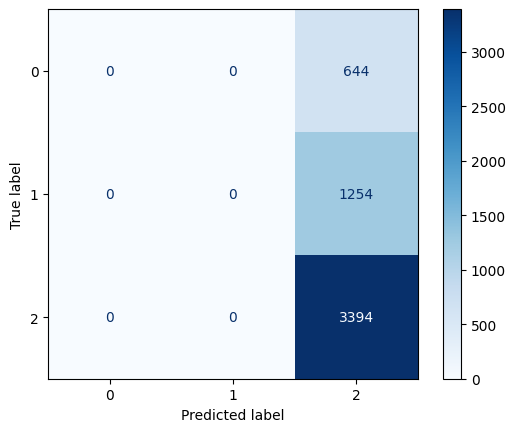

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       644
         1.0       0.00      0.00      0.00      1254
         2.0       0.64      1.00      0.78      3394

    accuracy                           0.64      5292
   macro avg       0.21      0.33      0.26      5292
weighted avg       0.41      0.64      0.50      5292



C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [152]:
# 정확도
SVC_acc = accuracy_score(y_test,SVC_pred)
print('정확도 :', SVC_acc)
# 혼동행렬
SVC_confusion = confusion_matrix(y_test,SVC_pred)
SVC_disp = ConfusionMatrixDisplay(SVC_confusion, display_labels=['0','1','2'])
SVC_disp.plot(cmap=plt.cm.Blues)
plt.show()
# 분석 보고서
SVC_classification_report = classification_report(y_test,SVC_pred)
print(SVC_classification_report)

## LightGBMClassifier

In [153]:
LGB_model = lightgbm.LGBMClassifier(random_state=7)
LGB_model.fit(x_train, y_train)
LGB_pred = LGB_model.predict(x_test)
print(LGB_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 28
[LightGBM] [Info] Start training from score -2.105335
[LightGBM] [Info] Start training from score -1.440314
[LightGBM] [Info] Start training from score -0.444193
[2. 2. 2. ... 0. 2. 2.]


정확도 : 0.7008692365835223


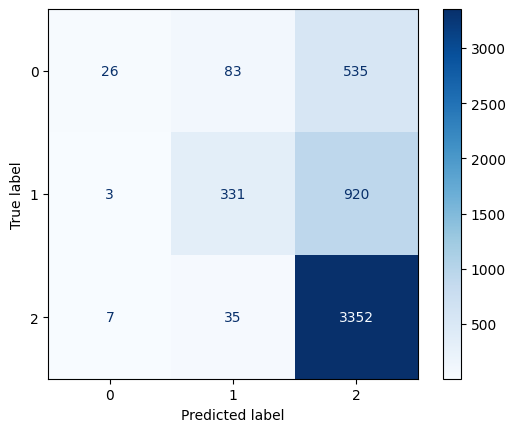

              precision    recall  f1-score   support

         0.0       0.72      0.04      0.08       644
         1.0       0.74      0.26      0.39      1254
         2.0       0.70      0.99      0.82      3394

    accuracy                           0.70      5292
   macro avg       0.72      0.43      0.43      5292
weighted avg       0.71      0.70      0.63      5292



In [154]:
# 정확도
LGB_acc = accuracy_score(y_test,LGB_pred)
print('정확도 :', LGB_acc)
# 혼동행렬
LGB_confusion = confusion_matrix(y_test,LGB_pred)
LGB_disp = ConfusionMatrixDisplay(LGB_confusion, display_labels=['0','1','2'])
LGB_disp.plot(cmap=plt.cm.Blues)
plt.show()
# 분석 보고서
LGB_classification_report = classification_report(y_test,LGB_pred)
print(LGB_classification_report)

## logistic Regression

In [155]:
LR_model = LogisticRegression()
LR_model.fit(x_train, y_train)
LR_pred = LR_model.predict(x_test)
print(LR_pred)

[2. 2. 2. ... 2. 2. 2.]


정확도 : 0.6413454270597128


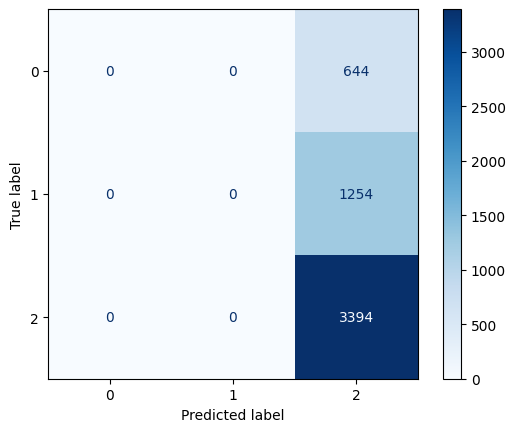

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       644
         1.0       0.00      0.00      0.00      1254
         2.0       0.64      1.00      0.78      3394

    accuracy                           0.64      5292
   macro avg       0.21      0.33      0.26      5292
weighted avg       0.41      0.64      0.50      5292



C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [156]:
# 정확도
LR_acc = accuracy_score(y_test,LR_pred)
print('정확도 :', LR_acc)
# 혼동행렬
LR_confusion = confusion_matrix(y_test,LR_pred)
LR_disp = ConfusionMatrixDisplay(LR_confusion, display_labels=['0','1','2'])
LR_disp.plot(cmap=plt.cm.Blues)
plt.show()
# 분석 보고서
LR_classification_report = classification_report(y_test,LR_pred)
print(LR_classification_report)

(0.0, 100.0)

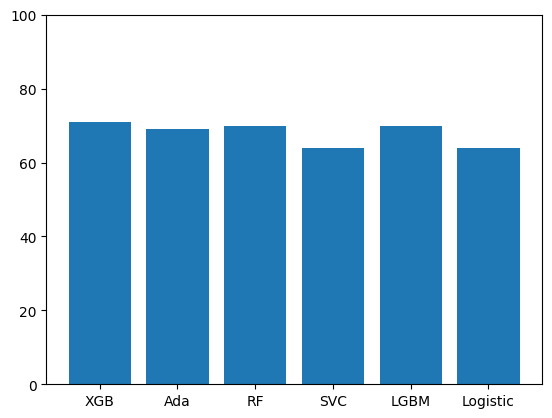

In [163]:
acc_score_name = ['XGB', 'Ada', 'RF', 'SVC', 'LGBM', 'Logistic']
acc_score = [71, 69, 70, 64, 70, 64 ]
plt.bar(acc_score_name, acc_score)
plt.ylim(0,100)